Desempaquetado de dataset con el id del archivo compartido de google drive.


In [ ]:
#Extraccion de dataset.zip de drive con id de documento compartido

!pip install -q gdown
!gdown --id 1rWGLHRAUvbniGP9Z6uydGqVFAw3ffKU5 --output archive.zip
!unzip -q archive.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1rWGLHRAUvbniGP9Z6uydGqVFAw3ffKU5
From (redirected): https://drive.google.com/uc?id=1rWGLHRAUvbniGP9Z6uydGqVFAw3ffKU5&confirm=t&uuid=4eff9bd3-75a8-41bd-9778-649fa8f3f0a8
To: /content/archive.zip
100% 1.10G/1.10G [00:16<00:00, 64.8MB/s]


# Verificar el balance de clases

In [ ]:
import os
from collections import Counter

directorio_base = '/content/asl_alphabet_train/asl_alphabet_train'
conteo = Counter()

for subcarpeta in os.listdir(directorio_base):
    ruta_subcarpeta = os.path.join(directorio_base, subcarpeta)
    if os.path.isdir(ruta_subcarpeta):
        num_imagenes = len(os.listdir(ruta_subcarpeta))
        conteo[subcarpeta] = num_imagenes

print("Cantidad de imágenes por clase:")
for clase, cantidad in conteo.items():
    print(f"{clase}: {cantidad}")

Cantidad de imágenes por clase:
del: 3000
E: 3000
Y: 3000
S: 3000
K: 3000
B: 3000
T: 3000
H: 3000
nothing: 3000
P: 3000
F: 3000
A: 3000
D: 3000
C: 3000
O: 3000
G: 3000
L: 3000
W: 3000
Z: 3000
space: 3000
X: 3000
V: 3000
Q: 3000
I: 3000
M: 3000
U: 3000
R: 3000
J: 3000
N: 3000


Importamos el modelo preentenado y las librerias necesarias, ademas de quitar la ultima capa del modelo para entrenar con nuestro dataset.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Parámetros
IMG_SIZE = 220
NUM_CLASSES = 29  # A-Z Nothing-delete-

# Base preentrenada
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = True  # Para transfer learning inicial

# Capas personalizadas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Modelo completo
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
model.save("modelo_senas.keras")


<ipython-input-3-2973171361>:12: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 220, 220,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 110, 110,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 110, 110,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 110, 110,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 110, 110,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 110, 110,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 110, 110,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 110, 110,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 110, 110,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 110, 110,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 110, 110,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 110, 110,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 111, 111,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 55, 55,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 55, 55,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 55, 55,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 55, 55,    │      2,304 │ block_1_depthwis

 Total params: 2,425,693 (9.25 MB)

 Trainable params: 2,391,581 (9.12 MB)

 Non-trainable params: 34,112 (133.25 KB)

## Se crea imagen del modelo para visualizar su composición.


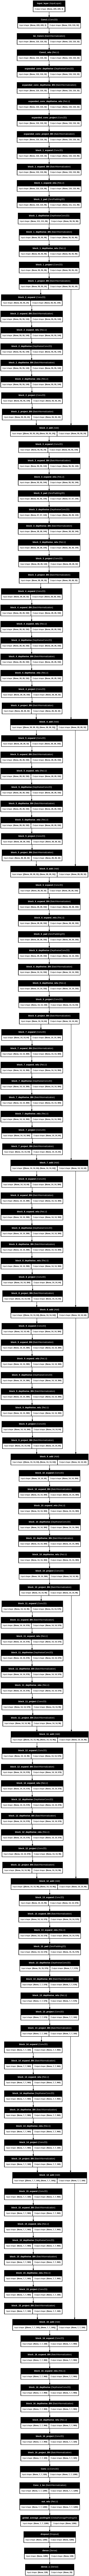

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file="modelo.png", show_shapes=True, show_layer_names=True)


# Se separan los datos en un factor 70% entrenamiento y 30% test para su respectivo entrenamiento.


In [ ]:
#Entrenamiento de la red neuronal con dataset cargado y descomprimido
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 220
BATCH_SIZE = 29

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    "asl_alphabet_train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    "asl_alphabet_train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)



Found 69600 images belonging to 1 classes.
Found 17400 images belonging to 1 classes.


# Se entrena el modelo con 20 pasadas por los datos.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',    # qué métrica mirar ('val_loss' o 'val_accuracy')
    patience=3,            # cuántas épocas esperar antes de parar (por ejemplo, 3)
    restore_best_weights=True  # restaura los mejores pesos encontrados
)
#Entrenamiento con los datos separados

history = model.fit(
    train_generator,
    epochs=20,
    validation_data = val_generator,
    callbacks=[early_stop]
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2400/2400 ━━━━━━━━━━━━━━━━━━━━ 307s 107ms/step - accuracy: 0.9825 - loss: 0.0884 - val_accuracy: 1.0000 - val_loss: 9.3559e-05
Epoch 2/20
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 254s 106ms/step - accuracy: 1.0000 - loss: 1.8486e-05 - val_accuracy: 1.0000 - val_loss: 4.4241e-06
Epoch 3/20
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 254s 106ms/step - accuracy: 1.0000 - loss: 2.9362e-06 - val_accuracy: 1.0000 - val_loss: 6.8048e-07
Epoch 4/20
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 256s 107ms/step - accuracy: 1.0000 - loss: 4.8999e-07 - val_accuracy: 1.0000 - val_loss: 1.1455e-07
Epoch 5/20
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 255s 106ms/step - accuracy: 1.0000 - loss: 7.5674e-08 - val_accuracy: 1.0000 - val_loss: 1.9841e-08
Epoch 6/20
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 257s 107ms/step - accuracy: 1.0000 - loss: 1.1742e-08 - val_accuracy: 1.0000 - val_loss: 4.2477e-09
Epoch 7/20
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 254s 106ms/step - accuracy: 1.0000 - loss: 1.5000e-09 - val_accuracy: 1.0000 - val_loss: 1.0619e-09
Epoch 8/20
2400/2400 

# Evaluacion del modelo

In [ ]:
# Evaluación del modelo con el conjunto de validación
loss, accuracy = model.evaluate(val_generator)
print(f"Pérdida en el conjunto de validación: {loss}")
print(f"Precisión en el conjunto de validación: {accuracy}")


600/600 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Pérdida en el conjunto de validación: 0.0
Precisión en el conjunto de validación: 1.0


# Guardar el modelo en el drive

In [ ]:
# guardar el modelo entrenado
from google.colab import drive
drive.mount('/content/drive')
import os
if not os.path.exists('/content/drive/MyDrive/models'):
    os.makedirs('/content/drive/MyDrive/models')
model.save('modelo_senas.keras')
model.save('/content/drive/MyDrive/models/modelo_senas.keras')
model.save('modelo_entrenado.h5')
model.save('/content/drive/MyDrive/models/modelo_entrenado.h5')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Se crean graficos para visualizar función de perdida y precisión.

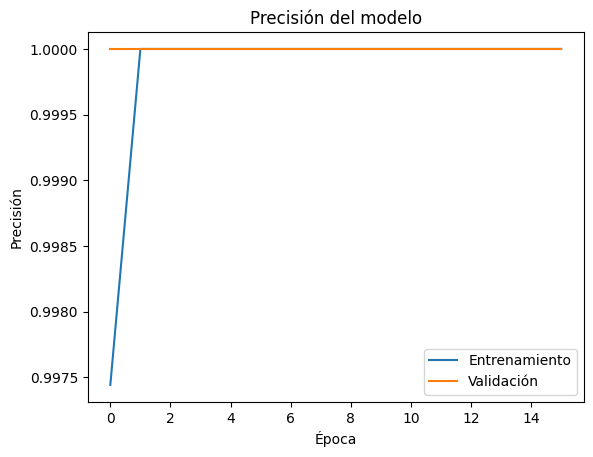

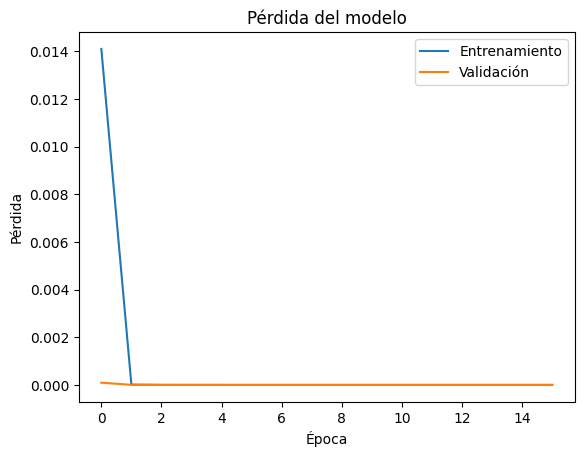

In [ ]:
import matplotlib.pyplot as plt

# Precisión
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Pérdida
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


Crear un grafico de dispersión para comprension de comportamiento del modelo.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Reset the validation generator and predict
val_generator.reset()
predictions = model.predict(val_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = val_generator.classes
class_indices = val_generator.class_indices
class_names = list(class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
print("Matriz de Confusión:")
print(cm)

# Classification Report
cr = classification_report(true_classes, predicted_classes, target_names=class_names)
print("\nInforme de Clasificación:")
print(cr)

600/600 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step
Matriz de Confusión:
[[17400]]

Informe de Clasificación:
                    precision    recall  f1-score   support

asl_alphabet_train       1.00      1.00      1.00     17400

          accuracy                           1.00     17400
         macro avg       1.00      1.00      1.00     17400
      weighted avg       1.00      1.00      1.00     17400



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Identificar las predicciones incorrectas
incorrect_indices = np.where(predicted_classes != true_classes)[0]

print(f"\nCantidad de predicciones incorrectas: {len(incorrect_indices)}")

# Mostrar ejemplos de predicciones incorrectas
if len(incorrect_indices) > 0:
  # Tomar hasta 10 ejemplos incorrectos para visualización
  num_examples_to_show = min(len(incorrect_indices), 10)
  incorrect_sample_indices = np.random.choice(incorrect_indices, num_examples_to_show, replace=False)

  plt.figure(figsize=(15, num_examples_to_show * 3))

  for i, incorrect_index in enumerate(incorrect_sample_indices):
    file_path = os.path.join(val_generator.directory, val_generator.filenames[incorrect_index])
    image = tf.keras.preprocessing.image.load_img(file_path, target_size=(IMG_SIZE, IMG_SIZE))
    image_array = tf.keras.preprocessing.image.img_to_array(image)

    true_label = class_names[true_classes[incorrect_index]]
    predicted_label = class_names[predicted_classes[incorrect_index]]

    plt.subplot(num_examples_to_show, 1, i + 1)
    plt.imshow(image_array.astype('uint8'))
    plt.title(f"Verdadero: {true_label}, Predicción: {predicted_label}", color='red')
    plt.axis('off')

  plt.tight_layout()
  plt.show()
else:
  print("No hay predicciones incorrectas para mostrar.")


Cantidad de predicciones incorrectas: 0
No hay predicciones incorrectas para mostrar.


# Cargar el modelo desde el drive previamente guardado

In [ ]:
# Cargar el entrenado desde el drive
from tensorflow.keras.models import load_model
from google.colab import drive
import os

# Permite el acceso a grandes cantidades de datos
drive.mount('/content/drive')

# Verifica que el directorio exista
print(f"Checking if directory exists: {os.path.exists('/content/drive/MyDrive/models')}")

# Verifica la lista de archivos y lista el contenido
print(f"Files in directory /content/drive/MyDrive/models:")
!ls -l /content/drive/MyDrive/models/

modelo_cargado = load_model('/content/drive/MyDrive/models/modelo_senas.keras')
model_charge = load_model('/content/drive/MyDrive/models/modelo_entrenado.h5')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Checking if directory exists: True
Files in directory /content/drive/MyDrive/models:
total 57703
-rw------- 1 root root 29548624 May 27 04:52 modelo_entrenado.h5
-rw------- 1 root root 29537901 May 27 04:52 modelo_senas.keras


# Se recrea el modelo para que carge los pesos


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

ruta_pesos = '/content/drive/MyDrive/models/modelo_entrenado.h5'
def crear_modelo(num_clases=29, img_size=220, cargar_pesos=True, ruta_pesos=None, val_generator=None):
    """
    Crea el modelo basado en MobileNetV2.

    Args:
        num_clases (int): Número de clases de salida.
        img_size (int): Tamaño de entrada de imagen (ancho y alto).
        cargar_pesos (bool): Si se desea cargar pesos entrenados.
        ruta_pesos (str): Ruta al archivo .h5 con los pesos entrenados.

    Returns:
        model (tf.keras.Model): Modelo listo para usar.
    """
    # Modelo base
    base_model = MobileNetV2(weights='imagenet', include_top=True, input_shape=(img_size, img_size, 3))
    base_model.trainable = True

    # Capas superiores
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    salida = Dense(num_clases, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=salida)

    # Cargar pesos si se solicita
    if cargar_pesos and ruta_pesos:
        try:
            model.load_weights(ruta_pesos)
            print("✅ Pesos cargados correctamente.")
        except Exception as e:
            print(f"❌ Error al cargar pesos: {e}")

    # Recompilar especificando el optimizador, la función de pérdida y las métricas
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Opcional: ejecutar una evaluación rápida para “construir” internamente las métricas
    if val_generator is not None:
        loss, acc = model.evaluate(val_generator, verbose=0)
        print(f"Pérdida: {loss:.4f}, Precisión: {acc:.4f}")

    return model


In [ ]:
#Entrenamiento de la red neuronal con dataset cargado y descomprimido
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 220
BATCH_SIZE = 29

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

train_generator = train_datagen.flow_from_directory(
    "asl_alphabet_train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory( # This line defines val_generator
    "asl_alphabet_train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)

Found 60900 images belonging to 1 classes.
Found 26100 images belonging to 1 classes.


Se revalua el modelo

In [ ]:
# Evaluación del modelo con el conjunto de validación
loss, accuracy = model.evaluate(val_generator)
print(f"Pérdida en el conjunto de validación: {loss}")
print(f"Precisión en el conjunto de validación: {accuracy}")

600/600 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Pérdida en el conjunto de validación: 0.0
Precisión en el conjunto de validación: 1.0


Verifica qué valores devuelve el modelo

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img("/content/asl_alphabet_test/asl_alphabet_test/H_test.jpg", target_size=(220, 220))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0

pred = model.predict(x)
print("Vector de predicciones:")
print(pred[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Vector de predicciones:
[1.00000000e+00 1.51335888e-11 1.67051546e-11 1.93981393e-11
 1.12973251e-11 1.95236379e-11 2.24051888e-11 3.43588977e-11
 2.72173221e-11 3.04531296e-11 1.68306202e-11 1.46724542e-11
 8.63447768e-12 2.23000108e-11 1.37866498e-11 1.32221265e-11
 2.64688896e-11 2.21839005e-11 4.24699997e-11 3.17020230e-11
 1.29343012e-11 1.53640815e-11 2.28928942e-11 2.37218526e-11
 1.08581911e-11 1.26182285e-11 2.20666662e-11 1.17945055e-11
 9.83923967e-12]


Funcion para pruebas del modelo con imagen que debes subir desde local

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import load_model

def subir_imagen():
    """
    Permite subir una imagen desde el computador en Google Colab.

    Returns:
        str: Ruta del archivo subido.
    """
    uploaded = files.upload()
    for nombre_archivo in uploaded.keys():
        return nombre_archivo  # Devuelve la primera imagen subida


Funcion para utilizar el modelo para prediccion

In [ ]:
def predecir_imagen(ruta_imagen, model):
    """
    Predice la clase de una imagen usando el modelo cargado.

    Args:
        ruta_imagen (str): Ruta a la imagen.

    Returns:
        tuple: (nombre_clase, probabilidad).
    """
    try:

        img = image.load_img(ruta_imagen, target_size=(220, 220))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = x / 255.0

        predicciones = model.predict(x)
        clase_predicha = np.argmax(predicciones[0])
        probabilidad = predicciones[0][clase_predicha]

        clases = list("ABCDFGHIJKLMNOPQRSTUVWXYZ")
        clases.extend(["nothing", "del"])
        nombre_clase = clases[clase_predicha]

        return nombre_clase, probabilidad
        # Verifica si es una letra A-Z
        if clase_predicha in list():
            return clase_predicha, probabilidad
        else:
            return None, None  # o return "No se encuentra ninguna letra ASL", None
    except Exception as e:
        print(f"❌ Error al procesar la imagen: {e}")
        return None, None


Subir imagen

In [ ]:
ruta = subir_imagen()  # o la ruta manual
nombre_clase, probabilidad = predecir_imagen(ruta, model)

if nombre_clase is not None and probabilidad is not None:
    print(f"Clase predicha: {nombre_clase}, Probabilidad: {probabilidad:.2f}")
else:
    print("No se pudo procesar la imagen o hacer la predicción.")


Saving C_test.jpg to C_test.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Clase predicha: A, Probabilidad: 1.00
